In [28]:
import pandas as pd
import re
pd.__version__

'2.1.1'

#### Comparing E-value Thresholds

In [166]:
model = "simple" #swap with default and blosum

In [168]:
i = 0.00001
while i <= 10:
  formatted_i = f"{i:.5f}"
#   if formatted_i == "0.00010": formatted_i = ".00010"
#   elif formatted_i == "0.00100": formatted_i = ".00100"
#   elif formatted_i == "0.01000": formatted_i = ".01000"
#   elif formatted_i == "0.10000": formatted_i = ".10000"
  input_file = f"../{model}_test/e_val/{formatted_i}_results.tbl"
  output_file = f"./{model}_analysis/e_val/{formatted_i}_cleaned_results.tbl"
  fixed_columns = 18  # Adjust this based on the number of fixed columns before the description

  with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
      for line in infile:
          if line.startswith('#'):
              # Skip comment lines
              outfile.write(line)
          else:
              # Step 1: Handle scientific notation spaces (e.g., 1.3e -73 -> 1.3e-73)
              line = re.sub(r'(\d\.\d+e)(\s*-?\d+)', r'\1\2', line)

              # Step 2: Split line into columns based on whitespace
              fields = line.split()

              # Step 3: Combine all columns after the first `fixed_columns` into a single description
              description = '/'.join(fields[fixed_columns:])  # Combine everything after the first 3 columns
              fields = fields[:fixed_columns] + [description]  # Keep the first few columns and add the full description

              # Step 4: Join the fields back with tabs
              fixed_line = '\t'.join(fields)

              # Write the cleaned line to the output file
              outfile.write(fixed_line + '\n')
  print(f"Cleaned file saved to {output_file}")

  i = i * 10

Cleaned file saved to ./simple_analysis/e_val/0.00001_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/0.00010_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/0.00100_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/0.01000_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/0.10000_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/1.00000_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/e_val/10.00000_cleaned_results.tbl


In [135]:
i = 0.00001
while i <= 10:
  formatted_i = f"{i:.5f}"
  if formatted_i == "0.00010": formatted_i = ".00010"
  elif formatted_i == "0.00100": formatted_i = ".00100"
  elif formatted_i == "0.01000": formatted_i = ".01000"
  elif formatted_i == "0.10000": formatted_i = ".10000"
  input_file = f"./{model}_analysis/e_val/{formatted_i}_cleaned_results.tbl"
  expected_columns = 19
  with open(input_file, 'r') as infile:
    for i, line in enumerate(infile, start=1):
        if not line.startswith('#'):  # Ignore comment lines
            # Split the line into columns
            columns = line.split()

            # Check if the number of columns is as expected
            if len(columns) != expected_columns:
                print(columns)
                print(f"{input_file}: Line {i} has {len(columns)} columns: {line.strip()}")

  i = i * 10

In [62]:

# for each of these get the df and check the threshold --> exclude and then find the accuracy precision 
output_file = f"./{model}_analysis/e_val/.00010_cleaned_results.tbl"
df = pd.read_csv(output_file, sep='\s+', comment='#', header=None)
df.head(3)
#df[0][0][-2:]
df.head(3)[df.head(3)[0].str.endswith("|NF") |df.head(3)[18].str.endswith("|NK") | df.head(3)[18].str.endswith("|NF")| df.head(3)[0].str.endswith("|NK") ]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,A2ASS6|reviewed|Titin|taxID:10090|NF,-,msa_train,-,0.000000e+00,2823.0,310.7,1.700000e-13,45.5,0.2,160.7,161,0,0,161,161,82,116,-
1,G4SLH0|reviewed|Titin,-,msa_train,-,2.400000e-209,673.1,95.2,5.800000e-11,37.4,0.1,48.7,50,0,0,50,50,18,25,homolog|taxID:6239|NF


In [136]:
# function that returns an array of TP, FP, TN, FN
def stats(e_val, model):
  print("-----------")
  formatted_i = f"{e_val:.5f}"
  print(formatted_i)
  
  file = f"./{model}_analysis/e_val/{formatted_i}_cleaned_results.tbl"
  df = pd.read_csv(file, sep='\s+', comment='#', header=None)
  print("original num hits: ", df.shape[0])

  conflicts = df[df[4] > e_val]
  if conflicts.empty: print(f"model: {model}, e_value: {e_val}: No conflicts.")
  else: 
    print(f"model: {model}, e_value: {e_val}: {conflicts}")
    print("num conflicts: ", conflicts.shape[0])
  df.drop(conflicts.index, inplace=True)
  print("filtered num hits: ", df.shape[0])

  num_hits = df.shape[0]
  pos_hits = df[df[0].str.endswith("|P") | df[18].str.endswith("|P")]
  negF_hits = df[df[0].str.endswith("|NF") | df[18].str.endswith("|NF")]
  negK_hits = df[df[0].str.endswith("|NK") | df[18].str.endswith("|NK")]
  print("false positives of F:", negF_hits.shape[0])
  print("false positive of K:", negK_hits.shape[0])

  true_neg = 221 - negF_hits.shape[0] - negK_hits.shape[0]
  false_neg = 221 - pos_hits.shape[0]
  return [pos_hits.shape[0], negF_hits.shape[0] + negK_hits.shape[0], true_neg, false_neg]

In [137]:
def acc_p_r(model):
  acc = []
  prec = []
  recall = []
  for i in [0.00001, 0.00010, 0.00100, 0.01000, .10000, 1, 10]:
    s = stats(i, model)
    acc.append((s[0] + s[2])/442)
    prec.append(s[0]/(s[0] + s[1]))
    recall.append(s[0]/(s[0] + s[3]))
  return acc, prec, recall

In [138]:
simple_acc, simple_prec, simple_recall = acc_p_r("simple")

-----------
0.00001
original num hits:  258
model: simple, e_value: 1e-05: No conflicts.
filtered num hits:  258
false positives of F: 47
false positive of K: 0
-----------
0.00010
original num hits:  261
model: simple, e_value: 0.0001: No conflicts.
filtered num hits:  261
false positives of F: 48
false positive of K: 0
-----------
0.00100
original num hits:  265
model: simple, e_value: 0.001: No conflicts.
filtered num hits:  265
false positives of F: 49
false positive of K: 0
-----------
0.01000
original num hits:  267
model: simple, e_value: 0.01: No conflicts.
filtered num hits:  267
false positives of F: 50
false positive of K: 0
-----------
0.10000
original num hits:  268
model: simple, e_value: 0.1: No conflicts.
filtered num hits:  268
false positives of F: 51
false positive of K: 0
-----------
1.00000
original num hits:  268
model: simple, e_value: 1: No conflicts.
filtered num hits:  268
false positives of F: 51
false positive of K: 0
-----------
10.00000
original num hits: 

In [139]:
default_acc, default_prec, default_recall = acc_p_r("default")

-----------
0.00001
original num hits:  271
model: default, e_value: 1e-05: No conflicts.
filtered num hits:  271
false positives of F: 50
false positive of K: 0
-----------
0.00010
original num hits:  272
model: default, e_value: 0.0001: No conflicts.
filtered num hits:  272
false positives of F: 51
false positive of K: 0
-----------
0.00100
original num hits:  274
model: default, e_value: 0.001: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
0.01000
original num hits:  274
model: default, e_value: 0.01: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
0.10000
original num hits:  274
model: default, e_value: 0.1: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
1.00000
original num hits:  274
model: default, e_value: 1: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
10.00000
original num 

In [140]:
blosum_acc, blosum_prec, blosum_recall = acc_p_r("blosum")

-----------
0.00001
original num hits:  271
model: blosum, e_value: 1e-05: No conflicts.
filtered num hits:  271
false positives of F: 50
false positive of K: 0
-----------
0.00010
original num hits:  272
model: blosum, e_value: 0.0001: No conflicts.
filtered num hits:  272
false positives of F: 51
false positive of K: 0
-----------
0.00100
original num hits:  274
model: blosum, e_value: 0.001: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
0.01000
original num hits:  274
model: blosum, e_value: 0.01: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
0.10000
original num hits:  274
model: blosum, e_value: 0.1: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
1.00000
original num hits:  274
model: blosum, e_value: 1: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
10.00000
original num hits: 

In [141]:
print(simple_acc)
print(default_acc)
print(blosum_acc)

[0.8710407239819005, 0.8733031674208145, 0.8778280542986425, 0.8778280542986425, 0.8755656108597285, 0.8755656108597285, 0.8755656108597285]
[0.8868778280542986, 0.8846153846153846, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565]
[0.8868778280542986, 0.8846153846153846, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565, 0.8800904977375565]


In [142]:
print(simple_prec)
print(default_prec)
print(blosum_prec)

[0.8178294573643411, 0.8160919540229885, 0.8150943396226416, 0.8127340823970037, 0.8097014925373134, 0.8097014925373134, 0.8097014925373134]
[0.8154981549815498, 0.8125, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934]
[0.8154981549815498, 0.8125, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934, 0.8065693430656934]


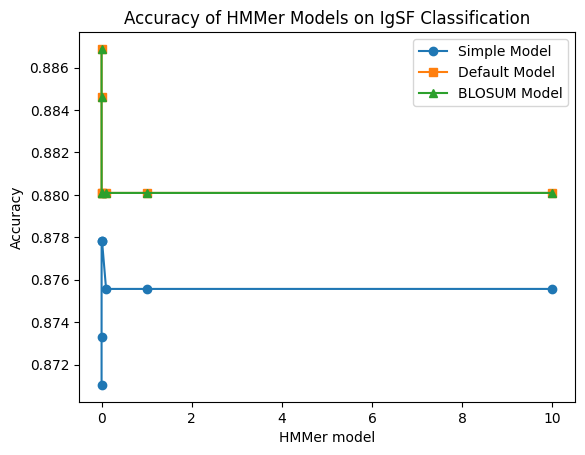

In [143]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis (it could be epochs, time, etc.)
x = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_acc, label='Simple Model', marker='o')
plt.plot(x, default_acc, label='Default Model', marker='s')
plt.plot(x, blosum_acc, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Accuracy')
plt.title('Accuracy of HMMer Models on IgSF Classification')

# Display a legend
plt.legend()

# Show the plot
plt.show()

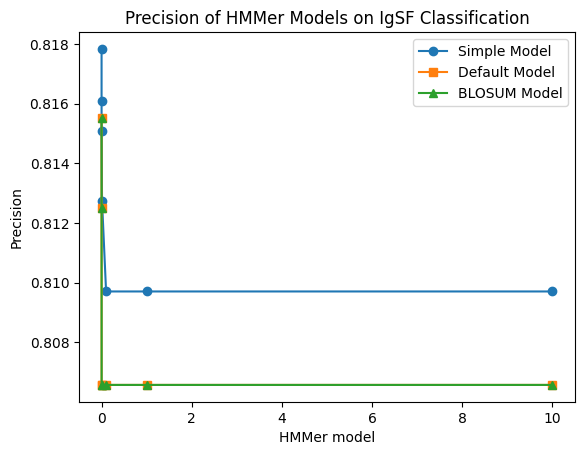

In [144]:
# X-axis (it could be epochs, time, etc.)
x = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_prec, label='Simple Model', marker='o')
plt.plot(x, default_prec, label='Default Model', marker='s')
plt.plot(x, blosum_prec, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Precision')
plt.title('Precision of HMMer Models on IgSF Classification')

# Display a legend
plt.legend()

# Show the plot
plt.show()

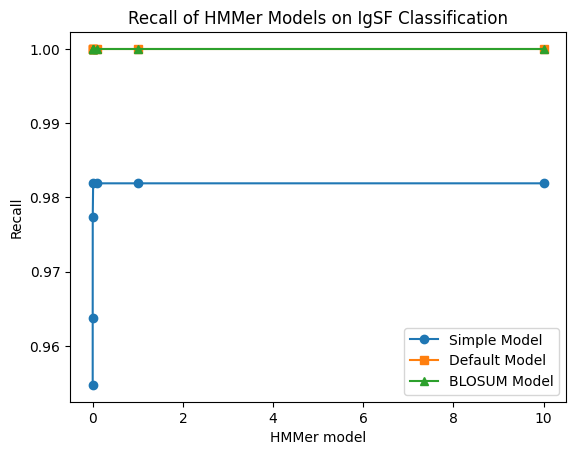

In [145]:
# X-axis (it could be epochs, time, etc.)
x = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_recall, label='Simple Model', marker='o')
plt.plot(x, default_recall, label='Default Model', marker='s')
plt.plot(x, blosum_recall, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Recall')
plt.title('Recall of HMMer Models on IgSF Classification')

# Display a legend
plt.legend()

# Show the plot
plt.show()

#### Comparing Bit Score Thresholds

In [148]:
model = "default" #swap with default and blosum

In [169]:
for i in [0,10,50,100]:

  input_file = f"../{model}_test/score/{i}_results.tbl"
  output_file = f"./{model}_analysis/score/{i}_cleaned_results.tbl"
  fixed_columns = 18  # Adjust this based on the number of fixed columns before the description

  with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
      for line in infile:
          if line.startswith('#'):
              # Skip comment lines
              outfile.write(line)
          else:
              # Step 1: Handle scientific notation spaces (e.g., 1.3e -73 -> 1.3e-73)
              line = re.sub(r'(\d\.\d+e)(\s*-?\d+)', r'\1\2', line)

              # Step 2: Split line into columns based on whitespace
              fields = line.split()

              # Step 3: Combine all columns after the first `fixed_columns` into a single description
              description = '/'.join(fields[fixed_columns:])  # Combine everything after the first 3 columns
              fields = fields[:fixed_columns] + [description]  # Keep the first few columns and add the full description

              # Step 4: Join the fields back with tabs
              fixed_line = '\t'.join(fields)

              # Write the cleaned line to the output file
              outfile.write(fixed_line + '\n')
  print(f"Cleaned file saved to {output_file}")

Cleaned file saved to ./simple_analysis/score/0_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/score/10_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/score/50_cleaned_results.tbl
Cleaned file saved to ./simple_analysis/score/100_cleaned_results.tbl


In [162]:
for i in [0,10,50,100]:

  input_file = f"./{model}_analysis/score/{i}_cleaned_results.tbl"
  expected_columns = 19
  with open(input_file, 'r') as infile:
    for i, line in enumerate(infile, start=1):
        if not line.startswith('#'):  # Ignore comment lines
            # Split the line into columns
            columns = line.split()

            # Check if the number of columns is as expected
            if len(columns) != expected_columns:
                print(columns)
                print(f"{input_file}: Line {i} has {len(columns)} columns: {line.strip()}")

In [163]:
# function that returns an array of TP, FP, TN, FN
def score_stats(score, model):
  print("-----------")
  
  file = f"./{model}_analysis/score/{score}_cleaned_results.tbl"
  df = pd.read_csv(file, sep='\s+', comment='#', header=None)
  print("original num hits: ", df.shape[0])

  conflicts = df[df[5] < score]
  if conflicts.empty: print(f"model: {model}, e_value: {score}: No conflicts.")
  else: 
    print(f"model: {model}, e_value: {score}: {conflicts}")
    print("num conflicts: ", conflicts.shape[0])
  df.drop(conflicts.index, inplace=True)
  print("filtered num hits: ", df.shape[0])

  num_hits = df.shape[0]
  pos_hits = df[df[0].str.endswith("|P") | df[18].str.endswith("|P")]
  negF_hits = df[df[0].str.endswith("|NF") | df[18].str.endswith("|NF")]
  negK_hits = df[df[0].str.endswith("|NK") | df[18].str.endswith("|NK")]
  print("false positives of F:", negF_hits.shape[0])
  print("false positive of K:", negK_hits.shape[0])

  true_neg = 221 - negF_hits.shape[0] - negK_hits.shape[0]
  false_neg = 221 - pos_hits.shape[0]
  return [pos_hits.shape[0], negF_hits.shape[0] + negK_hits.shape[0], true_neg, false_neg]

In [164]:
def score_acc_p_r(model):
  acc = []
  prec = []
  recall = []
  for i in [0, 10, 50, 100]:
    s = score_stats(i, model)
    acc.append((s[0] + s[2])/442)
    prec.append(s[0]/(s[0] + s[1]))
    recall.append(s[0]/(s[0] + s[3]))
  return acc, prec, recall

In [170]:
simple_acc, simple_prec, simple_recall = score_acc_p_r("simple")

-----------
original num hits:  268
model: simple, e_value: 0: No conflicts.
filtered num hits:  268
false positives of F: 51
false positive of K: 0
-----------
original num hits:  268
model: simple, e_value: 10: No conflicts.
filtered num hits:  268
false positives of F: 51
false positive of K: 0
-----------
original num hits:  169
model: simple, e_value: 50: No conflicts.
filtered num hits:  169
false positives of F: 40
false positive of K: 0
-----------
original num hits:  50
model: simple, e_value: 100: No conflicts.
filtered num hits:  50
false positives of F: 23
false positive of K: 0


In [171]:
default_acc, default_prec, default_recall = score_acc_p_r("default")

-----------
original num hits:  274
model: default, e_value: 0: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
original num hits:  274
model: default, e_value: 10: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
original num hits:  213
model: default, e_value: 50: No conflicts.
filtered num hits:  213
false positives of F: 44
false positive of K: 0
-----------
original num hits:  78
model: default, e_value: 100: No conflicts.
filtered num hits:  78
false positives of F: 33
false positive of K: 0


In [172]:
blosum_acc, blosum_prec, blosum_recall = score_acc_p_r("blosum")

-----------
original num hits:  274
model: blosum, e_value: 0: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
original num hits:  274
model: blosum, e_value: 10: No conflicts.
filtered num hits:  274
false positives of F: 53
false positive of K: 0
-----------
original num hits:  212
model: blosum, e_value: 50: No conflicts.
filtered num hits:  212
false positives of F: 45
false positive of K: 0
-----------
original num hits:  81
model: blosum, e_value: 100: No conflicts.
filtered num hits:  81
false positives of F: 33
false positive of K: 0


In [173]:
print(simple_acc)
print(default_acc)
print(blosum_acc)

[0.8755656108597285, 0.8755656108597285, 0.7013574660633484, 0.5090497737556561]
[0.8800904977375565, 0.8800904977375565, 0.7828054298642534, 0.5271493212669683]
[0.8800904977375565, 0.8800904977375565, 0.7760180995475113, 0.5339366515837104]


In [174]:
print(simple_prec)
print(default_prec)
print(blosum_prec)

[0.8097014925373134, 0.8097014925373134, 0.7633136094674556, 0.54]
[0.8065693430656934, 0.8065693430656934, 0.7934272300469484, 0.5769230769230769]
[0.8065693430656934, 0.8065693430656934, 0.7877358490566038, 0.5925925925925926]


In [175]:
print(simple_recall)
print(default_recall)
print(blosum_recall)

[0.9819004524886877, 0.9819004524886877, 0.583710407239819, 0.12217194570135746]
[1.0, 1.0, 0.7647058823529411, 0.20361990950226244]
[1.0, 1.0, 0.755656108597285, 0.2171945701357466]


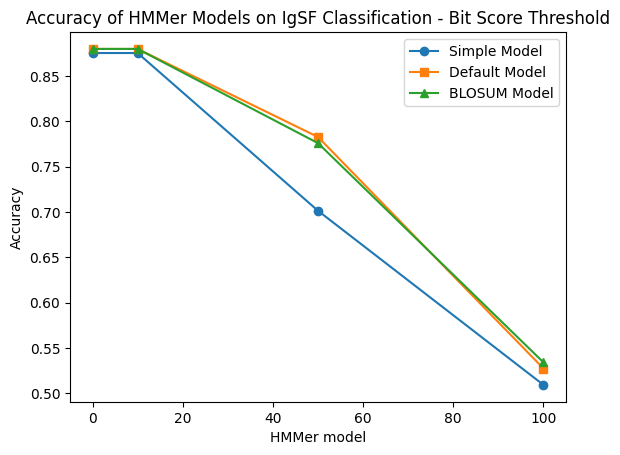

In [176]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis (it could be epochs, time, etc.)
x = [0,10,50,100]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_acc, label='Simple Model', marker='o')
plt.plot(x, default_acc, label='Default Model', marker='s')
plt.plot(x, blosum_acc, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Accuracy')
plt.title('Accuracy of HMMer Models on IgSF Classification - Bit Score Threshold')

# Display a legend
plt.legend()

# Show the plot
plt.show()

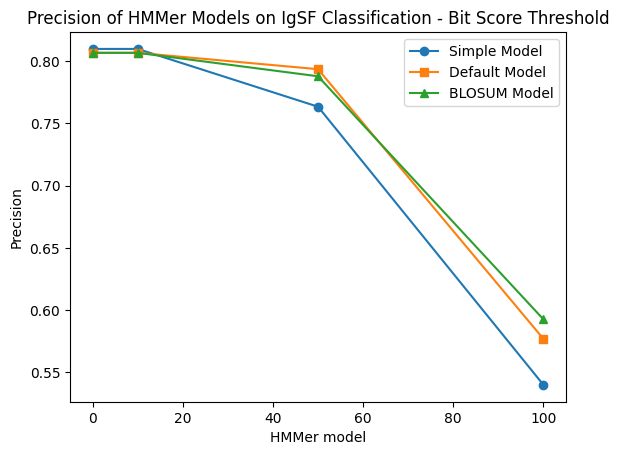

In [177]:
# X-axis (it could be epochs, time, etc.)
x = [0,10,50,100]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_prec, label='Simple Model', marker='o')
plt.plot(x, default_prec, label='Default Model', marker='s')
plt.plot(x, blosum_prec, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Precision')
plt.title('Precision of HMMer Models on IgSF Classification - Bit Score Threshold')

# Display a legend
plt.legend()

# Show the plot
plt.show()

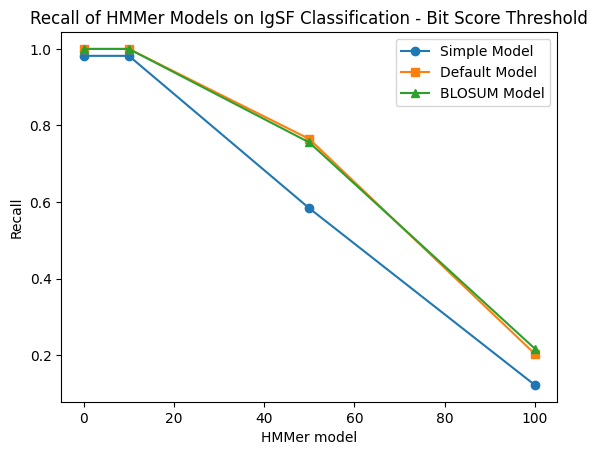

In [178]:
# X-axis (it could be epochs, time, etc.)
x = [0,10,50,100]
x = np.array(x)

# Plot each array as a separate line
plt.plot(x, simple_recall, label='Simple Model', marker='o')
plt.plot(x, default_recall, label='Default Model', marker='s')
plt.plot(x, blosum_recall, label='BLOSUM Model', marker='^')

# Add labels and a title
plt.xlabel('HMMer model')
plt.ylabel('Recall')
plt.title('Recall of HMMer Models on IgSF Classification - Bit Score Threshold')

# Display a legend
plt.legend()

# Show the plot
plt.show()